# Setup

In [1]:
pip install -r ../../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [3]:
# Add directory above current directory to path
import sys

sys.path.insert(0, '../..')

In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
import json
from utils.text_processing import CharTokenizer

In [6]:
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.get_memory_info("GPU:0")

2023-06-14 13:34:26.451880: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 13:34:26.987300: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-14 13:34:26.987351: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30945 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


In [7]:
config = json.load(open("./configs/mnn_em_glove.6B.300d_amazon.json"))

# Loading data

In [8]:
from data_loader.abo import ABO

In [9]:
data = ABO(path=config["data"]["path"],
           download=False,
           extract=False,
           preprocess=True,
           alt_augment=False,
           random_deletion=False,
           export_csv=True).data

# data = pd.read_csv(os.path.join(config["data"]["path"], "data.csv"))
# data = data.drop({"Unnamed: 0"}, axis=1)

data = data[['description', 'path', 'product_type', 'label']]
# data = data.sample(10000)
data

Loading images...
Loading texts...
Importing listings CSV...
Creating false samples/complement...
Merging ground truth and complement...
Concatenating attributes into description columns...
Finishing up...
Exporting to CSV...
Data processing complete


,description,path,product_type,label
0,mobile coverb081hp8fqnamazon brand - solimo de...,e0/e0dcad1a.jpg,CELLULAR_PHONE_CASE,1
1,kitchen containers for storageb0853xbhzmamazon...,b6/b608469a.jpg,HOME,0
2,mobile coverb07th2zwqsamazon brand - solimo de...,d6/d651034f.jpg,CELLULAR_PHONE_CASE,1
3,ac quiltb076bsftvwamazon brand - solimo arenda...,d5/d58e474d.jpg,HOME_BED_AND_BATH,1
4,mobile coverb07tgzz6v3amazon brand - solimo de...,14/1485f3b0.jpg,CELLULAR_PHONE_CASE,1
...,...,...,...,...
168160,mobile coverb07sykf3r4amazon brand - solimo de...,de/de494dfb.jpg,CELLULAR_PHONE_CASE,0
168161,metal metal shelving shelves garage shelves me...,92/9228a6f6.jpg,CELLULAR_PHONE_CASE,0
168162,mobile coverb07th3bq6vamazon brand - solimo de...,28/28dea160.jpg,CELLULAR_PHONE_CASE,1
168163,formal shoes for mens leatherb075t4vs6vamazon ...,fe/feba85ca.jpg,SHOES,1


In [10]:
img = data[["path"]]  # two brackets for keeping the column name
text = data["description"]
product_types = data[["product_type"]]
labels = data[["label"]]

# Text processing

This part is largely based off of https://keras.io/examples/nlp/pretrained_word_embeddings/

GloVe Embeddings: https://nlp.stanford.edu/projects/glove/

In [11]:
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=None, output_sequence_length=300)

vectorizer.adapt(text)

In [12]:
text = vectorizer(text).numpy()
text.shape

(168165, 300)

In [13]:
voc = vectorizer.get_vocabulary()
voc[:10]

['',
 '[UNK]',
 'mobile',
 'back',
 'brand',
 'for',
 'solimo',
 'cover',
 'case',
 'designer']

In [14]:
word_index = dict(zip(voc, range(len(voc))))

In [15]:
embeddings_index = {}
with open("./glove.6B.300d.txt") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [16]:
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 10305 words (153809 misses)


GloVe Embedding only converts less than 10% of data!

# Image processing

In [17]:
from utils.img_processing import load_img_model, create_embeddings_from

In [18]:
img_model = load_img_model(config["img_model"])

img_model.output_shape

(None, 576)

## Create image embeddings

In [19]:
%%time
# Mobilenetv3small:
# batch_size = 1024 -> 8 GB VRAM
# batch_size = 2048 -> 16 GB VRAM
# ...
# Mobilenetv3large: twice as much as Mobilenetv3small

img = create_embeddings_from(img_model,
                             img,
                             os.path.join(config["data"]["path"],
                                          "images/small"),
                             batch_size=4096)

Found 168165 validated image filenames.


2023-06-14 13:35:48.452420: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8700
2023-06-14 13:35:55.206146: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


CPU times: user 4min 29s, sys: 2min 48s, total: 7min 17s
Wall time: 12min 9s


In [20]:
img.shape

(168165, 576)

# Save embeddings

In [21]:
save_path = os.path.join(config["data"]["path"],
                         f"embeddings/glove/{img_model.name}")

In [22]:
os.makedirs(save_path, exist_ok=True)
np.save(f"{save_path}/img.npy", img)
np.save(f"{save_path}/text.npy", text)
data.to_csv(f"{save_path}/data.csv")

## Verify import

In [23]:
data = pd.read_csv(f"{save_path}/data.csv")
data = data.drop({"Unnamed: 0"}, axis=1)
data

,description,path,product_type,label
0,mobile coverb081hp8fqnamazon brand - solimo de...,e0/e0dcad1a.jpg,CELLULAR_PHONE_CASE,1
1,kitchen containers for storageb0853xbhzmamazon...,b6/b608469a.jpg,HOME,0
2,mobile coverb07th2zwqsamazon brand - solimo de...,d6/d651034f.jpg,CELLULAR_PHONE_CASE,1
3,ac quiltb076bsftvwamazon brand - solimo arenda...,d5/d58e474d.jpg,HOME_BED_AND_BATH,1
4,mobile coverb07tgzz6v3amazon brand - solimo de...,14/1485f3b0.jpg,CELLULAR_PHONE_CASE,1
...,...,...,...,...
168160,mobile coverb07sykf3r4amazon brand - solimo de...,de/de494dfb.jpg,CELLULAR_PHONE_CASE,0
168161,metal metal shelving shelves garage shelves me...,92/9228a6f6.jpg,CELLULAR_PHONE_CASE,0
168162,mobile coverb07th3bq6vamazon brand - solimo de...,28/28dea160.jpg,CELLULAR_PHONE_CASE,1
168163,formal shoes for mens leatherb075t4vs6vamazon ...,fe/feba85ca.jpg,SHOES,1


In [24]:
img = np.load(f"{save_path}/img.npy", allow_pickle=True)
img.shape

(168165, 576)

In [25]:
text = np.load(f"{save_path}/text.npy", allow_pickle=True)
text.shape

(168165, 300)

# Train-Test Split

To use `stratify` parameter of `sklearn.model_selection.train_test_split()`, we need to select all product instances which appear more than once

In [26]:
data["product_type_count"] = data.groupby(
    ["product_type"])["product_type"].transform("count")

data = data[data["product_type_count"] > config["data"]["cls"]]

In [27]:
# Update both columns
product_types = data[["product_type"]]

labels = data[["label"]]

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
train, test, labels_train, labels_test = train_test_split(
    data,
    labels,
    stratify=product_types,
    test_size=config["model"]["training"]["test_split"],
    random_state=42)

In [30]:
img_train = img[train.index]
img_test = img[test.index]

text_train = text[train.index]
text_test = text[test.index]

# Save Char CNN config

Not needed, as we use GloVe for text embeddings instead

In [31]:
# from models.char_cnn_zhang import CharCNNZhang

In [32]:
# char_cnn_config = {
#     "input_size": config["data"]["input_size"],
#     "embedding_size": len(tk.word_index),
#     "conv_layers": config["char_cnn_zhang"]["conv_layers"],
#     "fc_layers": config["char_cnn_zhang"]["fc_layers"],
#     "output_size": config["char_cnn_zhang"]["output_size"],
#     "embedding_weights": weights
# }

In [33]:
# char_cnn = CharCNNZhang(**char_cnn_config)

# Build MNN-EM Model

![](../../assets/images/MNN_EM.png)

In [34]:
# from models.mnn_em import MNNEM
from utils.metrics import create_metrics

In [35]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Multiply, BatchNormalization, Embedding, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision, BinaryAccuracy, CosineSimilarity


class MNNEMGlove(object):
    def __init__(
            self, head_config, combined_fc_layers, learning_rate,
            metrics=["recall", "precision", "binary_accuracy", "cosine_similarity"],
            loss='binary_crossentropy', name="MNN_EM") -> None:
        self.head_config = head_config
        self.combined_fc_layers = combined_fc_layers
        self.learning_rate = learning_rate
        self.metrics = metrics
        self.loss = loss
        self.name = name
        self._build_model()  # builds self.model variable

    def _build_model(self):
        # Input Layer
        img_features = Input(
            shape=(self.head_config["img_input_size"]), name="Image_Input")

        # Input Layer
        text_features = Input(
            shape=(self.head_config["txt_input_size"]), dtype=tf.int64, name="Text_Input")

        x = _MNNEMHead(**self.head_config)

        x = x.model([img_features, text_features])

        # FC Layers
        for i, comb_fl in enumerate(self.combined_fc_layers, 1):
            x = Dense(comb_fl, activation='relu',
                      name=f"Combined_FC_{i}")(x)

        output = Dense(1, activation='sigmoid', name="Sigmoid")(x)
        model = Model(inputs=[img_features, text_features],
                      outputs=output, name=self.name)

        optimizer = Adam(learning_rate=self.learning_rate)

        model.compile(optimizer=optimizer, loss=self.loss,
                      metrics=self.metrics)
        self.model = model
        # print("MNN-EM model built: ")
        # self.model.summary()


class _MNNEMHead(object):
    def __init__(self, img_input_size, txt_input_size, img_fc_layers,
                 txt_fc_layers, extended):
        self.img_input_size = img_input_size
        self.txt_input_size = txt_input_size
        self.img_fc_layers = img_fc_layers
        self.txt_fc_layers = txt_fc_layers
        self.extended = extended
        self._build_model()  # builds self.model variable

    def _build_model(self):
        # Text Input
        img_features = Input(shape=(self.img_input_size),
                             name="Image_Input_Head_Outer")

        img_cnn = _CNNBranch(self.img_input_size,
                             self.img_fc_layers, self.extended, name="Image")

        output_img = img_cnn.model(img_features)

        # Image Input
        text_features = Input(shape=(self.txt_input_size), dtype=tf.int64, name="Text_Input_Head_Outer")

        embedding_layer = Embedding(
            num_tokens,
            self.txt_input_size,
            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
            trainable=False,
        )

        x = embedding_layer(text_features)

        x = Flatten()(x)

        text_cnn = _CNNBranch(x.shape[1],
                             self.txt_fc_layers, self.extended, name="Text")

        output_text = text_cnn.model(x)

        # Element-wise product
        combined = Multiply(
            name="Element-wise_Multiplication")([output_img, output_text])

        model = Model(inputs=[img_features, text_features],
                      outputs=combined, name="MNN_EM_Head")

        self.model = model


class _CNNBranch(object):
    def __init__(self, input_size, fc_layers, extended, name):
        self.input_size = input_size
        self.fc_layers = fc_layers
        self.extended = extended
        self.name = name
        self._build_model()  # builds self.model variable

    def _build_model(self):
        # Input Layer
        features = Input(shape=(self.input_size),
                         name=f"{self.name}_Input_Head_Inner")

        # fc + ReLU
        for i, fl in enumerate(
                self.fc_layers[: None if self.extended else -1],
                1):
            x = Dense(fl, activation='relu',
                      name=f"{self.name}_FC_{i}")(features if i == 1 else x)

        if not self.extended:
            # fc + L2 Norm
            x = Dense(
                self.fc_layers[-1],
                kernel_regularizer='l2', name=f"{self.name}_FC_last")(
                features if len(self.fc_layers) == 1 else x)

        output = BatchNormalization(name=f"{self.name}_Batch_Normalization")(x)

        model = Model(inputs=features, outputs=output, name=f"{self.name}_CNN")

        self.model = model

In [36]:
head_config = {
    "img_input_size": img_model.layers[-1].output_shape[1],
    "txt_input_size": embedding_dim,
    "img_fc_layers": config["model"]["img_fc_layers"],
    "txt_fc_layers": config["model"]["txt_fc_layers"],
    "extended": False,
}

In [37]:
mnn_em = MNNEMGlove(head_config=head_config,
               combined_fc_layers=config["model"]["combined_fc_layers"],
               learning_rate=config["model"]["training"]["learning_rate"],
               metrics=create_metrics(config["model"]["training"]["metrics"]))

In [38]:
mnn_em.model.summary(expand_nested=True)

Model: "MNN_EM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input (InputLayer)       [(None, 576)]        0           []                               
                                                                                                  
 Text_Input (InputLayer)        [(None, 300)]        0           []                               
                                                                                                  
 MNN_EM_Head (Functional)       (None, 512)          143040368   ['Image_Input[0][0]',            
                                                                  'Text_Input[0][0]']             
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Text_Input_Head_Outer (InputLa  [(None, 300)]     0           []                           

In [39]:
# "Head"

tf.keras.utils.plot_model(mnn_em.model.layers[2],
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [40]:
# Image CNN

tf.keras.utils.plot_model(mnn_em.model.layers[2].layers[4],
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [41]:
# Full model

tf.keras.utils.plot_model(mnn_em.model,
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


# Callbacks

In [42]:
from utils.metrics import create_callbacks

In [43]:
log_dir = config["model"]["training"]["log_dir"]
model_name = config["model"]["name"]
optimizer_name = config["model"]["training"]["optimizer"]
learning_rate = config["model"]["training"]["learning_rate"]

In [44]:
callbacks = create_callbacks(
    callbacks_list=config["model"]["training"]["callbacks"],
    log_dir=log_dir,
    model_name=model_name,
    img_model_name=img_model.name,
    optimizer_name=optimizer_name,
    learning_rate=learning_rate,
    cls=config["data"]["cls"])

# Training

In [45]:
history = mnn_em.model.fit(
    x=[img_train, text_train],
    y=labels_train,
    epochs=config["model"]["training"]["epochs"],
    validation_split=config["model"]["training"]["validation_split"],
    batch_size=config["model"]["training"]["batch_size"],
    callbacks=callbacks)

Epoch 1/10
8513/8513 [==============================] - ETA: 0s - loss: 1.5606 - recall: 0.9217 - precision: 0.8827 - binary_accuracy: 0.8957 - cosine_similarity: 0.5192

2023-06-14 13:48:42.968646: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_GloVe.6B.300d_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_GloVe.6B.300d_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


8513/8513 [==============================] - 162s 19ms/step - loss: 1.5606 - recall: 0.9217 - precision: 0.8827 - binary_accuracy: 0.8957 - cosine_similarity: 0.5192 - val_loss: 0.3542 - val_recall: 0.9384 - val_precision: 0.9214 - val_binary_accuracy: 0.9253 - val_cosine_similarity: 0.5273
Epoch 2/10
8513/8513 [==============================] - ETA: 0s - loss: 0.2502 - recall: 0.9652 - precision: 0.9407 - binary_accuracy: 0.9503 - cosine_similarity: 0.5192

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_GloVe.6B.300d_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_GloVe.6B.300d_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


8513/8513 [==============================] - 161s 19ms/step - loss: 0.2502 - recall: 0.9652 - precision: 0.9407 - binary_accuracy: 0.9503 - cosine_similarity: 0.5192 - val_loss: 0.2411 - val_recall: 0.9694 - val_precision: 0.9411 - val_binary_accuracy: 0.9519 - val_cosine_similarity: 0.5273
Epoch 3/10
8509/8513 [============================>.] - ETA: 0s - loss: 0.1942 - recall: 0.9746 - precision: 0.9573 - binary_accuracy: 0.9643 - cosine_similarity: 0.5192

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_GloVe.6B.300d_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_GloVe.6B.300d_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


8513/8513 [==============================] - 164s 19ms/step - loss: 0.1942 - recall: 0.9746 - precision: 0.9573 - binary_accuracy: 0.9643 - cosine_similarity: 0.5192 - val_loss: 0.2117 - val_recall: 0.9741 - val_precision: 0.9508 - val_binary_accuracy: 0.9598 - val_cosine_similarity: 0.5274
Epoch 4/10
8510/8513 [============================>.] - ETA: 0s - loss: 0.1651 - recall: 0.9802 - precision: 0.9664 - binary_accuracy: 0.9720 - cosine_similarity: 0.5192

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_GloVe.6B.300d_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_GloVe.6B.300d_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


8513/8513 [==============================] - 162s 19ms/step - loss: 0.1651 - recall: 0.9802 - precision: 0.9663 - binary_accuracy: 0.9720 - cosine_similarity: 0.5192 - val_loss: 0.2067 - val_recall: 0.9805 - val_precision: 0.9460 - val_binary_accuracy: 0.9602 - val_cosine_similarity: 0.5273
Epoch 5/10
8513/8513 [==============================] - ETA: 0s - loss: 0.1455 - recall: 0.9829 - precision: 0.9727 - binary_accuracy: 0.9768 - cosine_similarity: 0.5192

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_GloVe.6B.300d_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_GloVe.6B.300d_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


8513/8513 [==============================] - 162s 19ms/step - loss: 0.1455 - recall: 0.9829 - precision: 0.9727 - binary_accuracy: 0.9768 - cosine_similarity: 0.5192 - val_loss: 0.1933 - val_recall: 0.9717 - val_precision: 0.9626 - val_binary_accuracy: 0.9652 - val_cosine_similarity: 0.5273
Epoch 6/10
8513/8513 [==============================] - ETA: 0s - loss: 0.1341 - recall: 0.9845 - precision: 0.9756 - binary_accuracy: 0.9792 - cosine_similarity: 0.5192

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_GloVe.6B.300d_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_GloVe.6B.300d_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


8513/8513 [==============================] - 162s 19ms/step - loss: 0.1341 - recall: 0.9845 - precision: 0.9756 - binary_accuracy: 0.9792 - cosine_similarity: 0.5192 - val_loss: 0.1733 - val_recall: 0.9831 - val_precision: 0.9596 - val_binary_accuracy: 0.9693 - val_cosine_similarity: 0.5273
Epoch 7/10
8513/8513 [==============================] - 66s 8ms/step - loss: 0.1234 - recall: 0.9865 - precision: 0.9793 - binary_accuracy: 0.9822 - cosine_similarity: 0.5192 - val_loss: 0.1986 - val_recall: 0.9645 - val_precision: 0.9642 - val_binary_accuracy: 0.9624 - val_cosine_similarity: 0.5273
Epoch 8/10
8513/8513 [==============================] - ETA: 0s - loss: 0.1153 - recall: 0.9871 - precision: 0.9806 - binary_accuracy: 0.9832 - cosine_similarity: 0.5192

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_GloVe.6B.300d_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_GloVe.6B.300d_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


8513/8513 [==============================] - 162s 19ms/step - loss: 0.1153 - recall: 0.9871 - precision: 0.9806 - binary_accuracy: 0.9832 - cosine_similarity: 0.5192 - val_loss: 0.1648 - val_recall: 0.9807 - val_precision: 0.9651 - val_binary_accuracy: 0.9711 - val_cosine_similarity: 0.5273
Epoch 9/10
8513/8513 [==============================] - 66s 8ms/step - loss: 0.1065 - recall: 0.9885 - precision: 0.9834 - binary_accuracy: 0.9853 - cosine_similarity: 0.5192 - val_loss: 0.1701 - val_recall: 0.9832 - val_precision: 0.9621 - val_binary_accuracy: 0.9707 - val_cosine_similarity: 0.5274
Epoch 10/10
8513/8513 [==============================] - ETA: 0s - loss: 0.1019 - recall: 0.9894 - precision: 0.9840 - binary_accuracy: 0.9861 - cosine_similarity: 0.5192

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_GloVe.6B.300d_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_GloVe.6B.300d_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


8513/8513 [==============================] - 162s 19ms/step - loss: 0.1019 - recall: 0.9894 - precision: 0.9840 - binary_accuracy: 0.9861 - cosine_similarity: 0.5192 - val_loss: 0.1588 - val_recall: 0.9848 - val_precision: 0.9682 - val_binary_accuracy: 0.9750 - val_cosine_similarity: 0.5272


# Evaluation

## Plot loss and metrics

In [46]:
from utils.metrics import plot_metrics

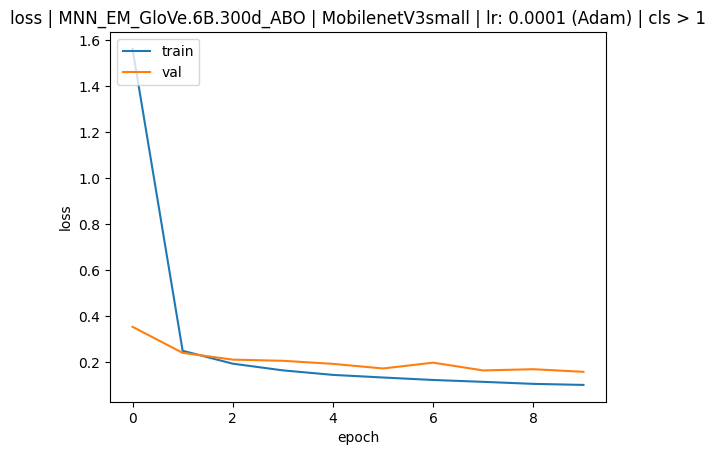

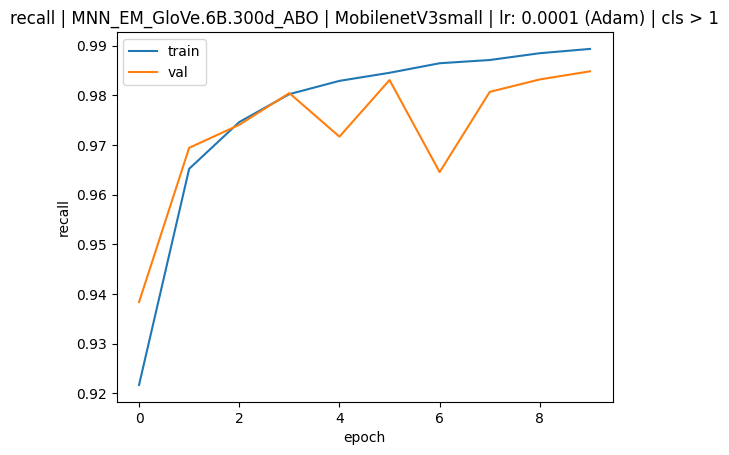

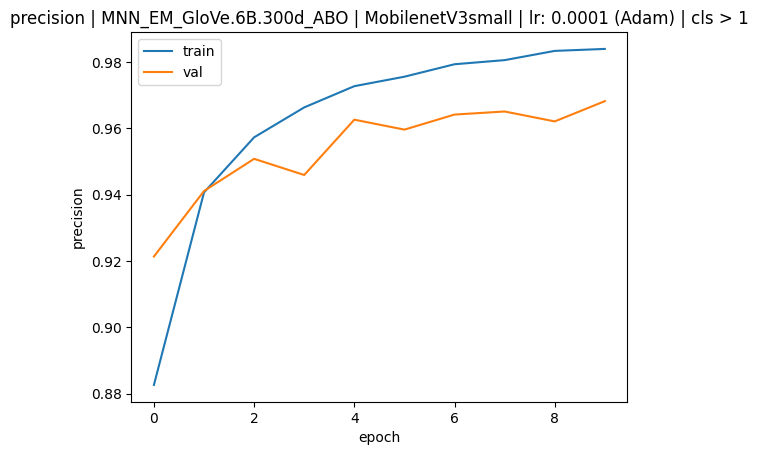

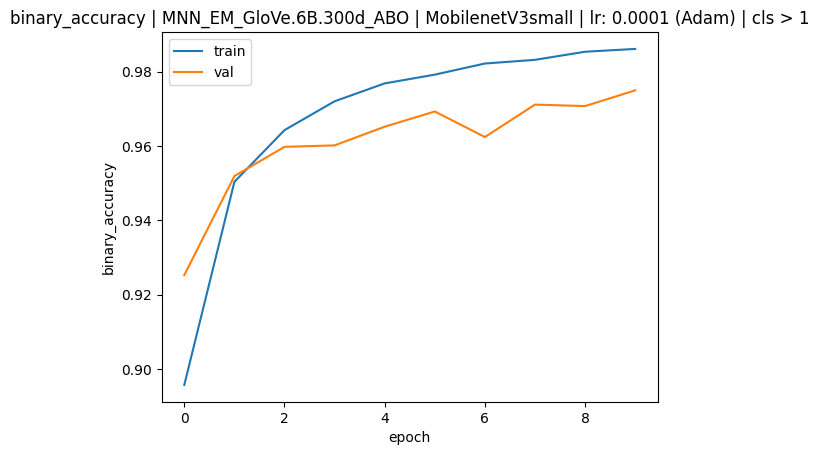

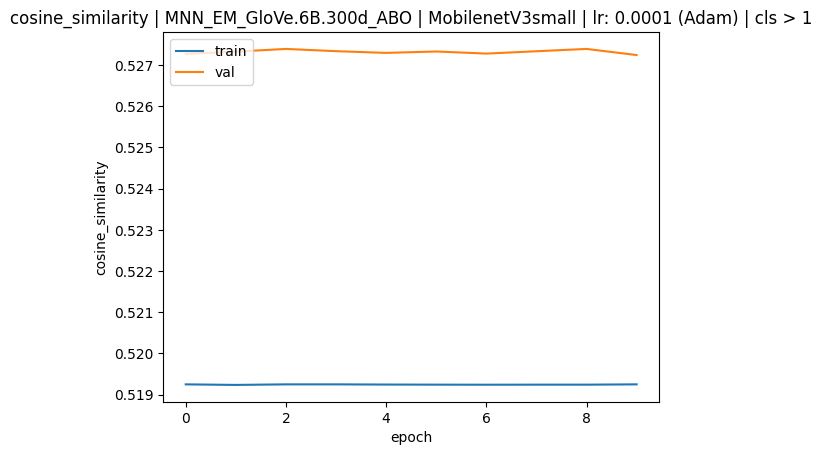

In [47]:
plot_metrics(history.history, config["model"]["training"]["metrics"],
             model_name, img_model.name, optimizer_name, learning_rate,
             config["data"]["cls"])

## Evaluate model and save metrics

In [48]:
from utils.metrics import evaluate

In [49]:
evaluate(mnn_em.model, [img_test, text_test], labels_test, log_dir, model_name,
         img_model.name, optimizer_name, learning_rate, config["data"]["cls"])

16814/16814 [==============================] - 40s 2ms/step - loss: 0.1642 - recall: 0.9856 - precision: 0.9650 - binary_accuracy: 0.9741 - cosine_similarity: 0.5154
